## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_agi')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_turing')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_parity')
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 24.5,
 5: 26.0,
 10: 26.8,
 20: 27.7,
 30: 28.6,
 40: 29.8,
 50: 31.4,
 60: 33.4,
 70: 35.6,
 80: 38.1,
 90: 41.7,
 95: 44.7,
 99: 50.6}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

# del delay['real_world_feedback']
# del delay['robotics']
delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=1.7, sd=0.37)
   - <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=1.15, sd=0.7)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=1.5, sd=0.49)
   - <Distribution> lognorm(mean=2.3, sd=0.42)},
 'real_world_feedback': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=1.7, sd=0.37)
   - <Distribution> lognorm(mean=2.85, sd=0.33)},
 'policy_pause': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2, 3),         # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 43.6 log FLOP (~40 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~340 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 4.0 years to a max of 0.086601% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.0 max log FLOP (99 septillion) available - TAI takes 43.6 log FLOP (40 billion decillion) - log $ 25.3 to buy TAI (20 septillion) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (152 septillion) available - TAI takes 43.3 log FLOP (20 billion decillion) - log $ 24.9 to buy TAI (8 septillion) vs. willingness to pay log $ 7.8 (59 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLOP 

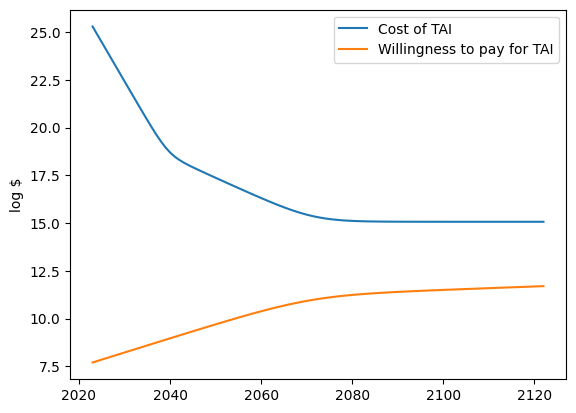

-
-
## SAMPLE RUN 2 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.8 max log FLOP (697 septillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (59 billion) vs. willingness to pay log $ 8.6 (438 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3 max log FLOP (2 octillion) available - 

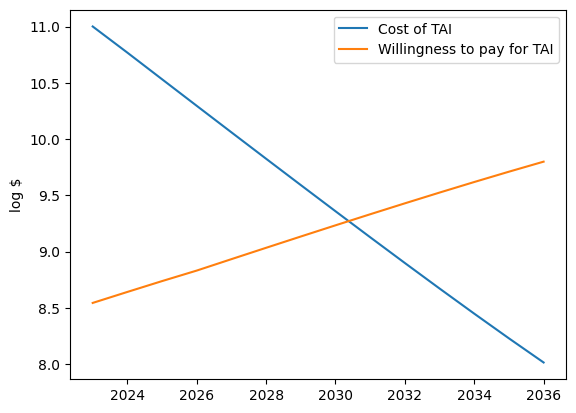

-
-
## SAMPLE RUN 3 ##
It takes 28.0 log FLOP (~10 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~232 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 2.6 years to a max of 0.040645% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.1 max log FLOP (124 septillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (214 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 7.9 (81 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (367 septillion) available - T

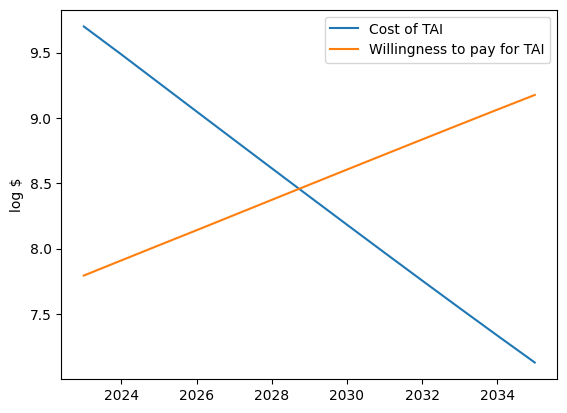

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 172.05it/s]


Shuffling data...
Waiting for other cores...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1307.61it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2031',
 '15%: 2032',
 '20%: 2034',
 '25%: 2035',
 '35%: 2038',
 '50%: 2044',
 '60%: 2050',
 '75%: 2095',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 7 years from now',
 '10%: 8 years from now',
 '15%: 9 years from now',
 '20%: 11 years from now',
 '25%: 12 years from now',
 '35%: 15 years from now',
 '50%: 21 years from now',
 '60%: 27 years from now',
 '75%: 72 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.2%
2028-2029: 3.8%
2030-2034: 19.8%
2035-2039: 16.8%
2040-2049: 18.1%
2050-2059: 9.2%
2060-2069: 4.0%
2070-2079: 1.6%
2080-2089: 1.0%
2090-2099: 0.7%
2100-2109: 0.8%
2110-2119: 0.4%
>2120: 23.6%
-
-
## 

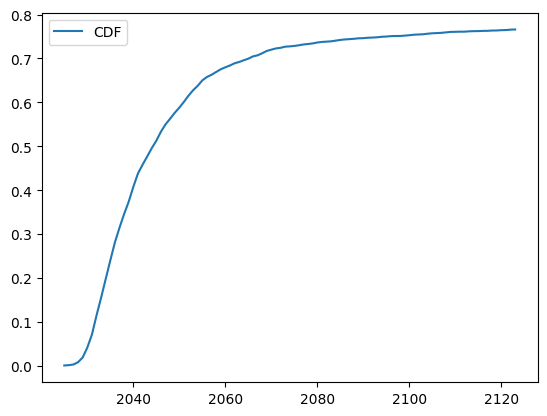

<string>:162: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

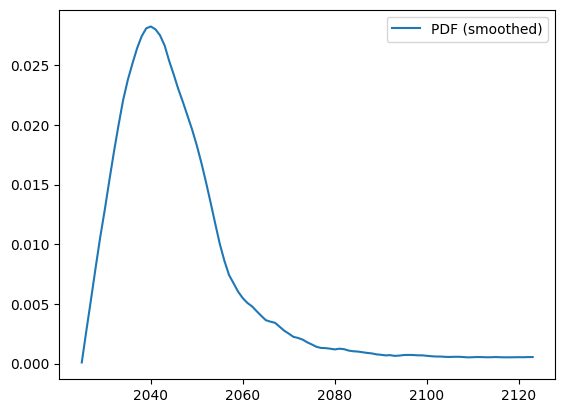

-
-
## TAI FLOP SIZE ##
{1: 24.9,
 5: 26.1,
 10: 26.8,
 20: 27.8,
 30: 28.7,
 40: 29.7,
 50: 31.4,
 60: 33.4,
 70: 35.9,
 80: 38.4,
 90: 42.1,
 95: 45.2,
 99: 50.8}


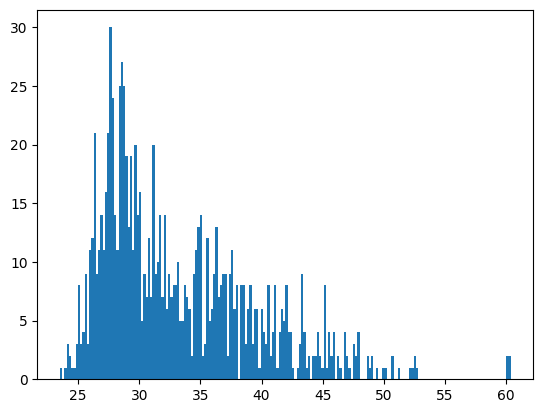

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.3,
 5: 3.0,
 10: 2.9,
 20: 2.7,
 30: 2.6,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.3,
 80: 2.2,
 90: 2.1,
 95: 2.0,
 99: 1.8}


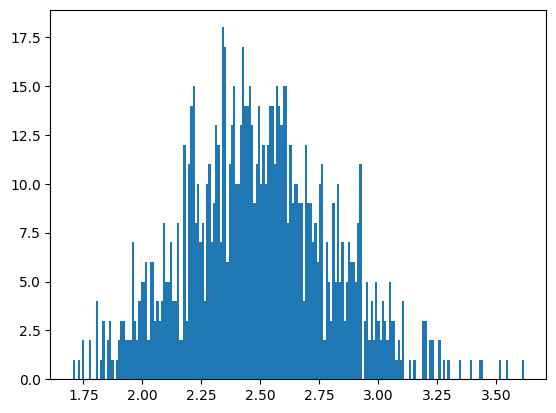

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.4,
 5: 21.0,
 10: 21.3,
 20: 21.7,
 30: 22.0,
 40: 22.3,
 50: 22.5,
 60: 22.7,
 70: 23.0,
 80: 23.2,
 90: 23.6,
 95: 24.0,
 99: 25.0}


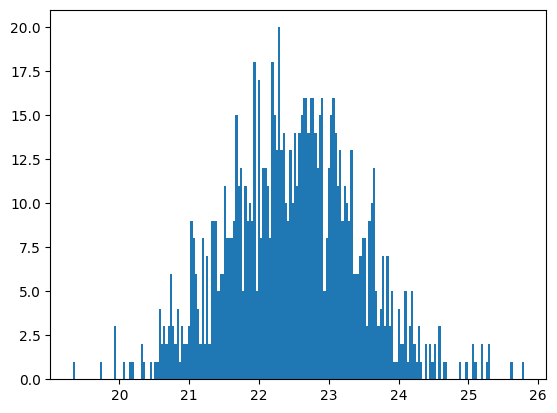

-
-
## INITIAL PAY ##
{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.1,
 95: 9.3,
 99: 10.0}


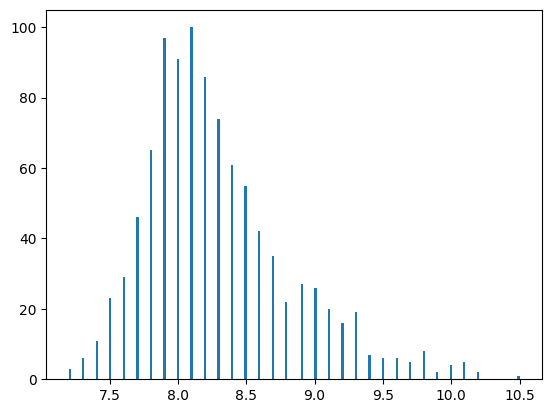

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}


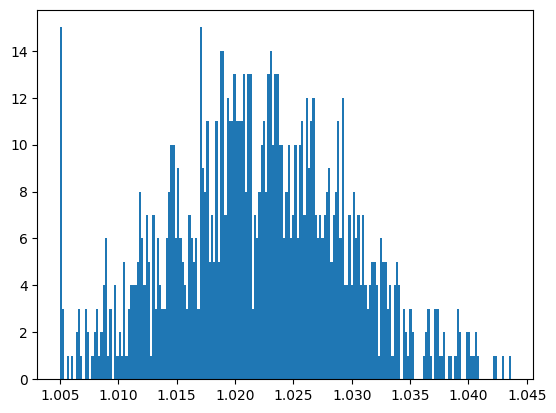

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.00039,
 60: 0.00049,
 70: 0.00066,
 80: 0.00104,
 90: 0.00203,
 95: 0.00328,
 99: 0.0097}


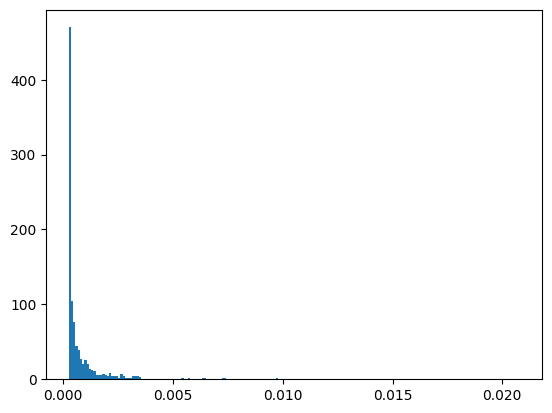

-
-
## SPEND DOUBLING TIME ##
{1: 5.2,
 5: 4.5,
 10: 4.2,
 20: 3.8,
 30: 3.5,
 40: 3.3,
 50: 3.1,
 60: 2.9,
 70: 2.6,
 80: 2.4,
 90: 2.0,
 95: 1.5,
 99: 1.0}


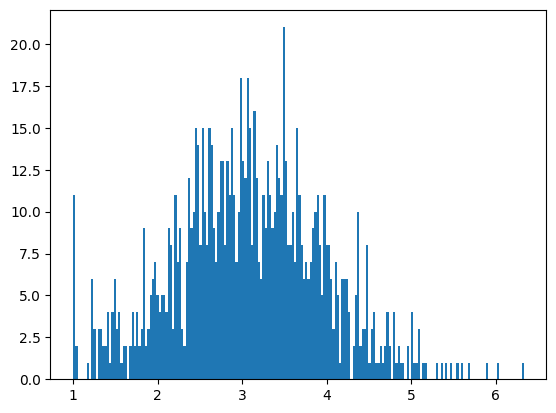

-
-
-
-
## GDP Over Time ##


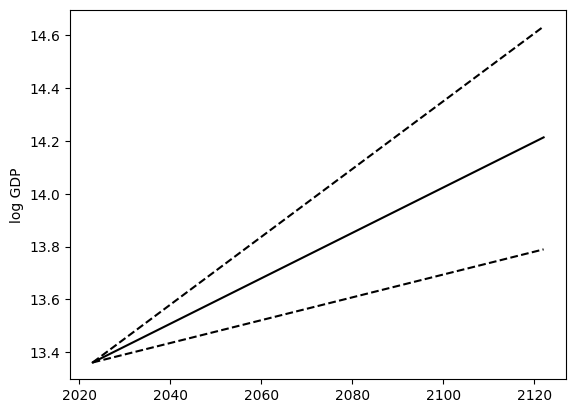

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

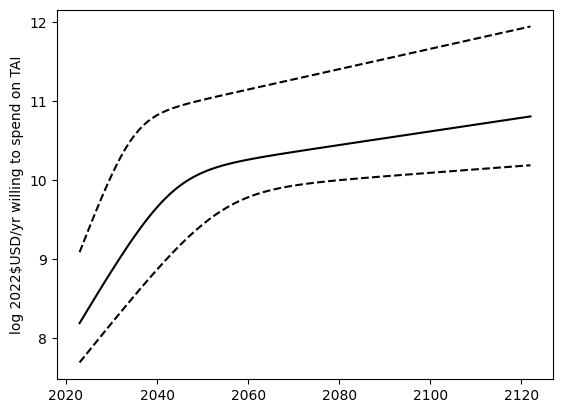

Year: 2023 - willingness log 2022$USD per year 8.2 (~156 million) 90% CI 7.7 (~50 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.3 (~194 million) 90% CI 7.8 (~59 million) - 9.2 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.4 (~241 million) 90% CI 7.8 (~69 million) - 9.4 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.5 (~300 million) 90% CI 7.9 (~81 million) - 9.5 (~3 billion)
Year: 2027 - willingness log 2022$USD per year 8.6 (~373 million) 90% CI 8.0 (~95 million) - 9.7 (~5 billion)
Year: 2028 - willingness log 2022$USD per year 8.7 (~462 million) 90% CI 8.1 (~112 million) - 9.8 (~6 billion)
Year: 2029 - willingness log 2022$USD per year 8.8 (~572 million) 90% CI 8.1 (~132 million) - 9.9 (~9 billion)
Year: 2030 - willingness log 2022$USD per year 8.8 (~706 million) 90% CI 8.2 (~155 million) - 10.1 (~11 billion)
Year: 2031 - willingness log 2022$USD per year 8.9 (~870 million) 90% CI 8.3 (~182 million) - 10.2 (~15 billion)
Ye

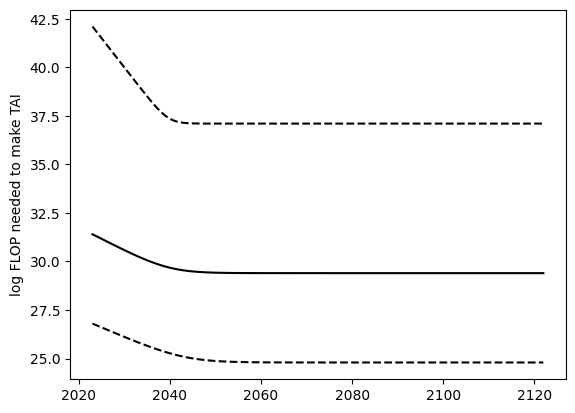

Year: 2023 - log FLOP needed for TAI 31.4 (~25 nonillion) 90% CI 26.8 (~631 septillion) - 42.1 (~1 billion decillion)
Year: 2024 - log FLOP needed for TAI 31.3 (~19 nonillion) 90% CI 26.7 (~507 septillion) - 41.8 (~629 million decillion)
Year: 2025 - log FLOP needed for TAI 31.2 (~15 nonillion) 90% CI 26.6 (~404 septillion) - 41.5 (~315 million decillion)
Year: 2026 - log FLOP needed for TAI 31.0 (~11 nonillion) 90% CI 26.5 (~322 septillion) - 41.2 (~157 million decillion)
Year: 2027 - log FLOP needed for TAI 30.9 (~9 nonillion) 90% CI 26.4 (~257 septillion) - 40.9 (~79 million decillion)
Year: 2028 - log FLOP needed for TAI 30.8 (~7 nonillion) 90% CI 26.3 (~205 septillion) - 40.6 (~39 million decillion)
Year: 2029 - log FLOP needed for TAI 30.7 (~5 nonillion) 90% CI 26.2 (~164 septillion) - 40.3 (~20 million decillion)
Year: 2030 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 26.1 (~132 septillion) - 40.0 (~10 million decillion)
Year: 2031 - log FLOP needed for TAI 30.5 (~3 noni

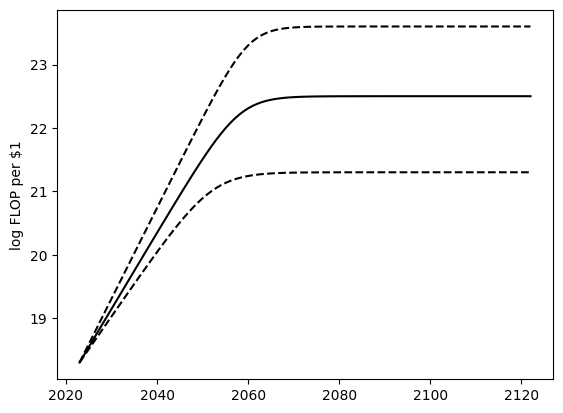

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.6 (~4 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.7 (~5 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 18.9 (~7 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~7 quintillion) - 19.0 (~10 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.9 (~8 quintillion) - 19.2 (~14 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 19.0 (~11 quintillion) - 19.3 (~20 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.1 (~13 quintillion) - 19.4 (~28 quint

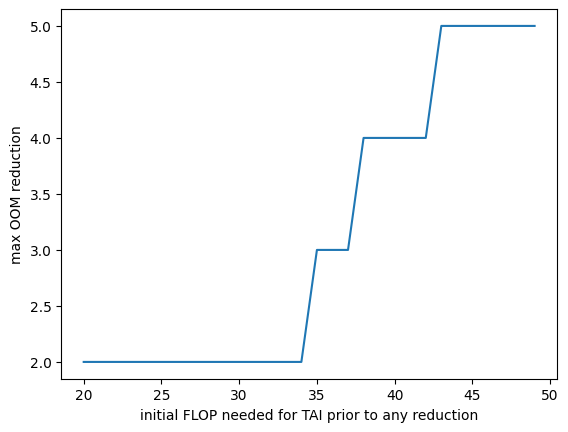

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

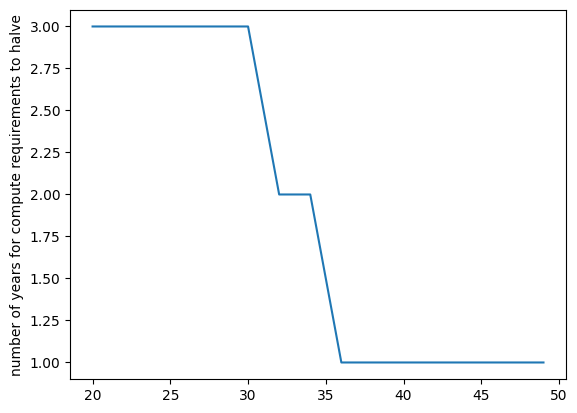

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

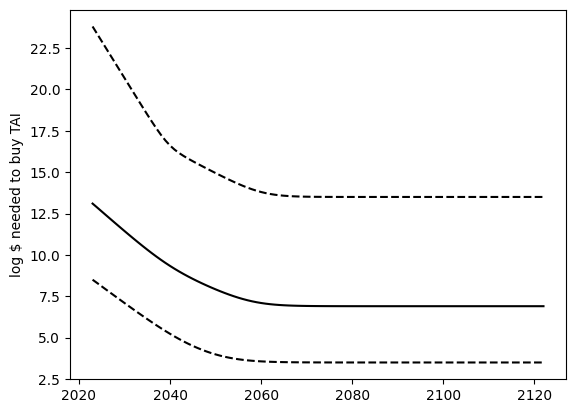

Year: 2023 - 13.1 log 2022$USD to buy TAI (~13 trillion) 90% CI 8.5 (~317 million) - 23.8 (~631 sextillion)
Year: 2024 - 12.9 log 2022$USD to buy TAI (~7 trillion) 90% CI 8.3 (~200 million) - 23.4 (~227 sextillion)
Year: 2025 - 12.6 log 2022$USD to buy TAI (~4 trillion) 90% CI 8.1 (~126 million) - 22.9 (~82 sextillion)
Year: 2026 - 12.4 log 2022$USD to buy TAI (~2 trillion) 90% CI 7.9 (~79 million) - 22.5 (~29 sextillion)
Year: 2027 - 12.1 log 2022$USD to buy TAI (~1 trillion) 90% CI 7.7 (~50 million) - 22.0 (~11 sextillion)
Year: 2028 - 11.9 log 2022$USD to buy TAI (~819 billion) 90% CI 7.5 (~31 million) - 21.6 (~4 sextillion)
Year: 2029 - 11.7 log 2022$USD to buy TAI (~476 billion) 90% CI 7.3 (~20 million) - 21.1 (~1 sextillion)
Year: 2030 - 11.4 log 2022$USD to buy TAI (~278 billion) 90% CI 7.1 (~12 million) - 20.7 (~490 quintillion)
Year: 2031 - 11.2 log 2022$USD to buy TAI (~163 billion) 90% CI 6.9 (~8 million) - 20.2 (~176 quintillion)
Year: 2032 - 11.0 log 2022$USD to buy TAI (~

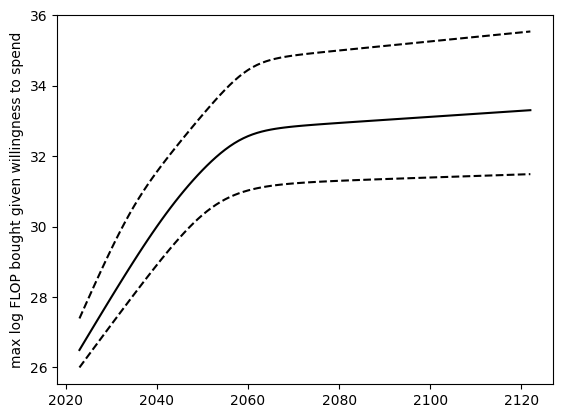

Year: 2023 - max log FLOP 26.5 (~311 septillion) 90% CI 26.0 (~99 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log FLOP 26.7 (~511 septillion) 90% CI 26.2 (~148 septillion) - 27.7 (~5 octillion)
Year: 2025 - max log FLOP 26.9 (~839 septillion) 90% CI 26.3 (~221 septillion) - 28.0 (~9 octillion)
Year: 2026 - max log FLOP 27.1 (~1 octillion) 90% CI 26.5 (~331 septillion) - 28.3 (~18 octillion)
Year: 2027 - max log FLOP 27.4 (~2 octillion) 90% CI 26.7 (~494 septillion) - 28.5 (~34 octillion)
Year: 2028 - max log FLOP 27.6 (~4 octillion) 90% CI 26.9 (~738 septillion) - 28.8 (~65 octillion)
Year: 2029 - max log FLOP 27.8 (~6 octillion) 90% CI 27.0 (~1 octillion) - 29.1 (~123 octillion)
Year: 2030 - max log FLOP 28.0 (~10 octillion) 90% CI 27.2 (~2 octillion) - 29.4 (~230 octillion)
Year: 2031 - max log FLOP 28.2 (~16 octillion) 90% CI 27.4 (~2 octillion) - 29.6 (~420 octillion)
Year: 2032 - max log FLOP 28.4 (~26 octillion) 90% CI 27.6 (~4 octillion) - 29.9 (~755 octillion)
Year: 2033

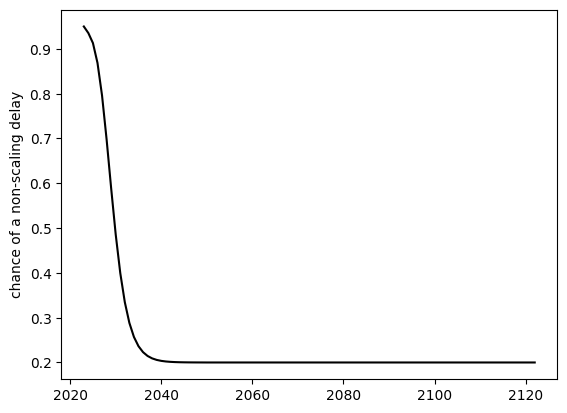

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 94%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 91%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 87%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2033

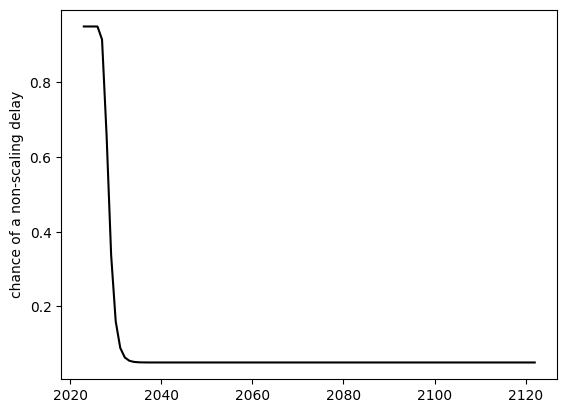

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 92%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 66%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2033 -

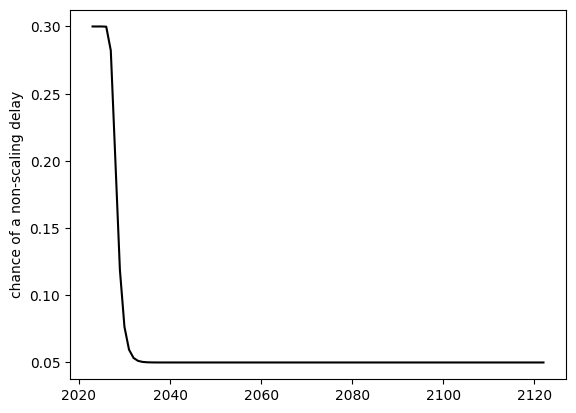

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - 

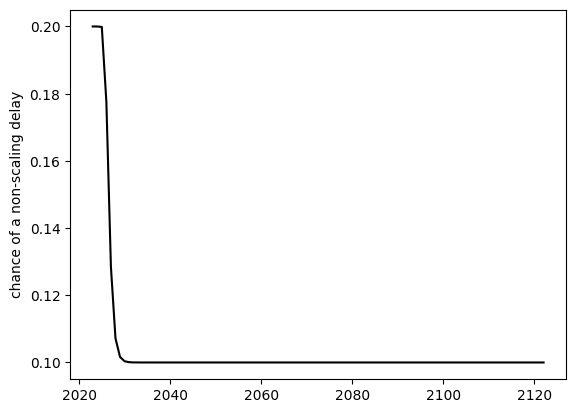

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

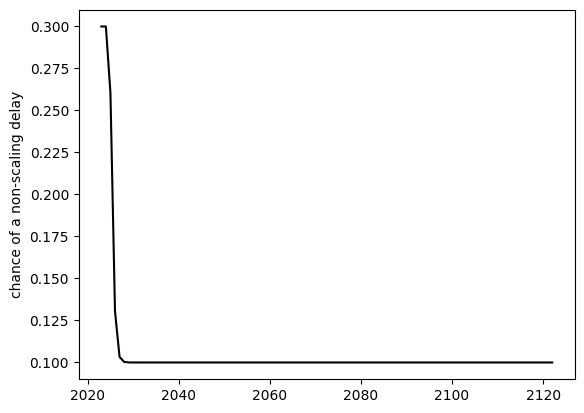

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

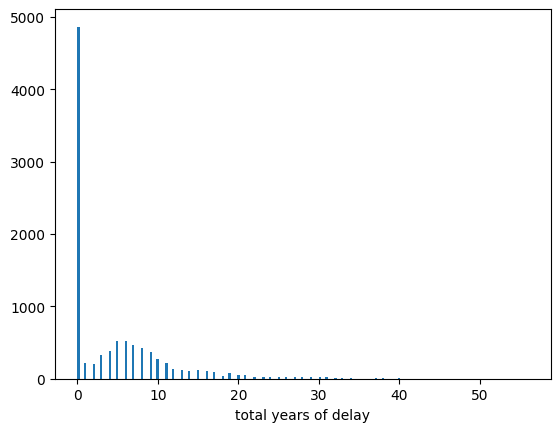

In [7]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 29.5 log FLOP (~316 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~46 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~378 million). This doubles every 1.6 years to a max of 0.033123% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.9 max log FLOP (719 septillion) available - TAI takes 29.5 log FLOP (316 octillion) - log $ 11.2 to buy TAI (158 billion) vs. willingness to pay log $ 8.6 (360 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 29.4 log FLOP (254 octillion) - log $ 11.0 to buy TAI (96 billion) vs. willingness to pay log $ 8.7 (545 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) availabl

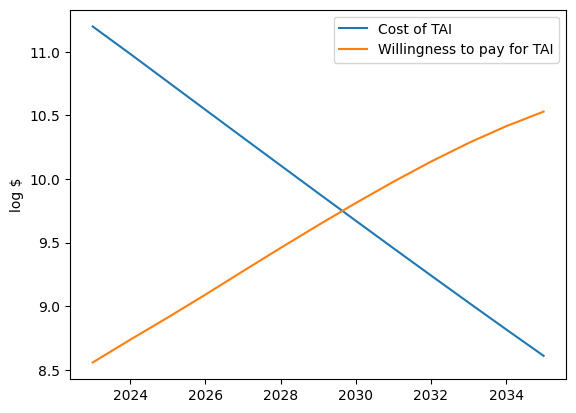

-
-
## SAMPLE RUN 5 ##
It takes 38.5 log FLOP (~316 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 3.4 years to a max of 0.165523% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.8 max log FLOP (620 septillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.2 to buy TAI (159 quintillion) vs. willingness to pay log $ 8.5 (311 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (982 septillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.8 to buy TAI (61 quintillion) vs. willingness to pay log $ 8.6 (381 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 

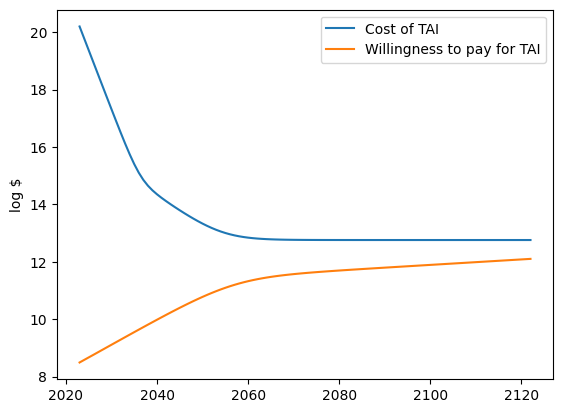

-
-
## SAMPLE RUN 6 ##
It takes 31.1 log FLOP (~13 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 5.0 years to a max of 0.061676% of GDP. GDP grows at a rate of 1.007x per year.
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 31.1 log FLOP (13 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (231 septillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 12.6 to buy TAI (4 trillion) vs. willingness to pay log $ 8.0 (90 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (340 septillion) available 

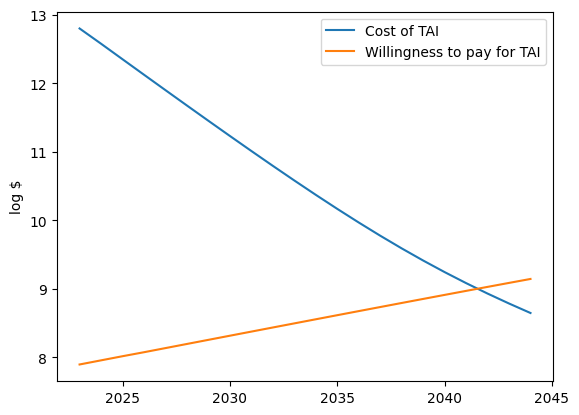

-
-
## SAMPLE RUN 7 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 9.5 log 2022$USD (~3 billion). This doubles every 4.0 years to a max of 0.04919% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.8 to buy TAI (631 quadrillion) vs. willingness to pay log $ 9.4 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.9 max log FLOP (7 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.4 to buy TAI (237 quadrillion) vs. willingness to pay log $ 9.4 (3 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 28.0 max log FLOP (11 octilli

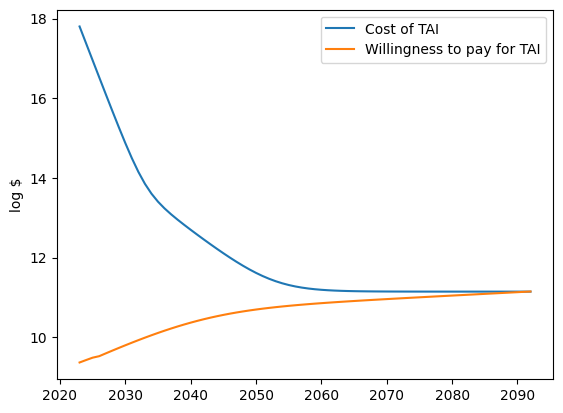

-
-
## SAMPLE RUN 8 ##
It takes 32.8 log FLOP (~631 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~1 billion). This doubles every 1 years to a max of 0.083697% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 32.8 log FLOP (631 nonillion) - log $ 14.5 to buy TAI (316 trillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 32.7 log FLOP (452 nonillion) - log $ 14.3 to buy TAI (180 trillion) vs. willingness to pay log $ 9.4 (3 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 28.2 max log FLOP (14 octillion) available - TAI 

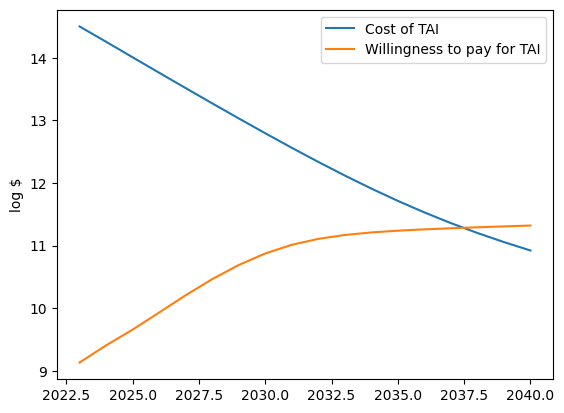

-
-
## SAMPLE RUN 9 ##
It takes 29.8 log FLOP (~631 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 3.6 years to a max of 0.036956% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.1 max log FLOP (124 septillion) available - TAI takes 29.8 log FLOP (631 octillion) - log $ 11.5 to buy TAI (316 billion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (203 septillion) available - TAI takes 29.7 log FLOP (507 octillion) - log $ 11.3 to buy TAI (187 billion) vs. willingness to pay log $ 7.9 (75 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (333 septillion) avail

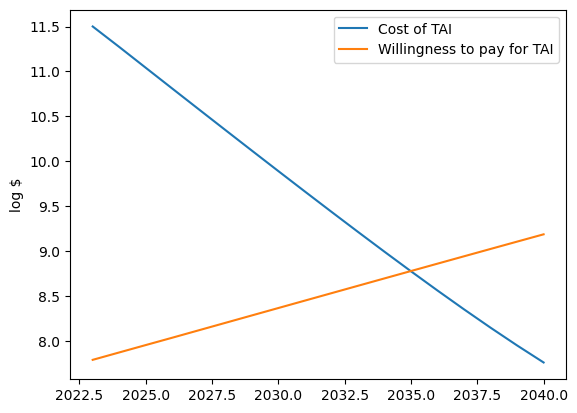

-
-
## SAMPLE RUN 10 ##
It takes 47.0 log FLOP (~100 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 20.1 log FLOP (~115 quintillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~62 million). This doubles every 3.2 years to a max of 0.027238% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.1 max log FLOP (121 septillion) available - TAI takes 47.0 log FLOP (100 trillion decillion) - log $ 28.7 to buy TAI (51 octillion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (195 septillion) available - TAI takes 46.7 log FLOP (50 trillion decillion) - log $ 28.3 to buy TAI (20 octillion) vs. willingness to pay log $ 7.9 (76 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max l

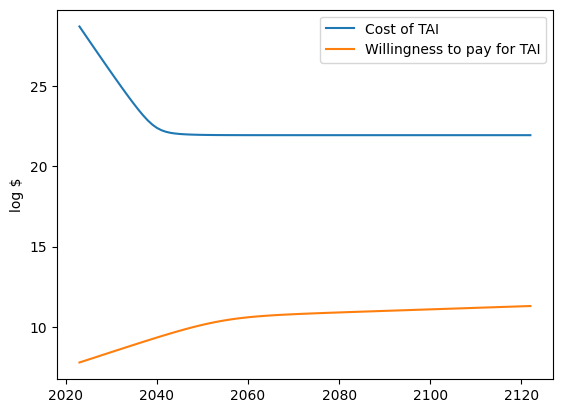

-
-
## SAMPLE RUN 11 ##
It takes 38.3 log FLOP (~200 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~38 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 2.3 years to a max of 0.205891% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.1 max log FLOP (126 septillion) available - TAI takes 38.3 log FLOP (200 thousand decillion) - log $ 20.0 to buy TAI (100 quintillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (230 septillion) available - TAI takes 38.0 log FLOP (100 thousand decillion) - log $ 19.6 to buy TAI (37 quintillion) vs. willingness to pay log $ 7.9 (85 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 m

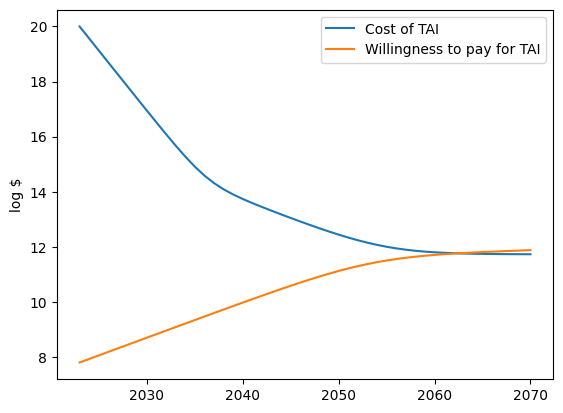

-
-
## SAMPLE RUN 12 ##
It takes 39.6 log FLOP (~4 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~982 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 2.5 years to a max of 0.365007% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 27.4 max log FLOP (2 octillion) available - TAI takes 39.6 log FLOP (4 million decillion) - log $ 21.3 to buy TAI (2 sextillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 39.3 log FLOP (2 million decillion) - log $ 20.9 to buy TAI (765 quintillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.9 max log FLOP (7 octil

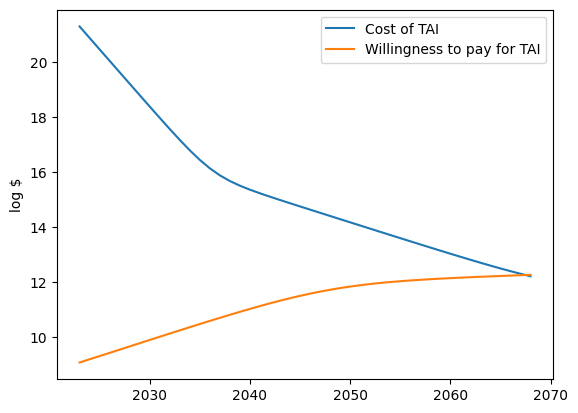

-
-
## SAMPLE RUN 13 ##
It takes 29.2 log FLOP (~158 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~28 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 1.3 years to a max of 0.063642% of GDP. GDP grows at a rate of 1.005x per year.
---
Year: 2023 - 26.4 max log FLOP (247 septillion) available - TAI takes 29.2 log FLOP (158 octillion) - log $ 10.9 to buy TAI (79 billion) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (531 septillion) available - TAI takes 29.1 log FLOP (127 octillion) - log $ 10.7 to buy TAI (49 billion) vs. willingness to pay log $ 8.3 (206 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) avail

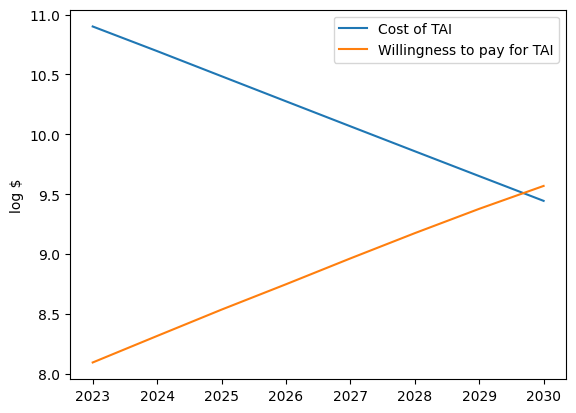

-
-
## SAMPLE RUN 14 ##
It takes 27.6 log FLOP (~4 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 3.3 years to a max of 0.049572% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.4 max log FLOP (245 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.1 (123 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (386 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.2 (152 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (606 septillion) available - TAI

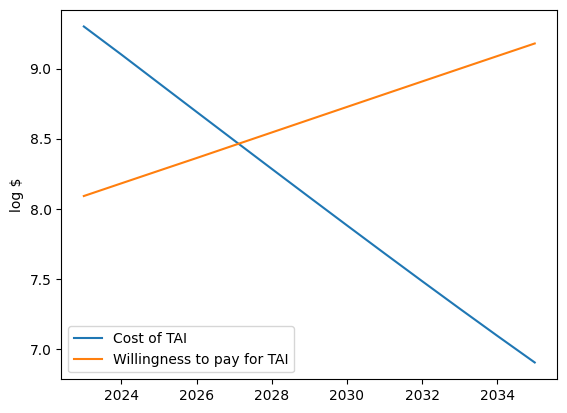

-
-
## SAMPLE RUN 15 ##
It takes 37.2 log FLOP (~16 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~308 million). This doubles every 4.6 years to a max of 0.050609% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.8 max log FLOP (598 septillion) available - TAI takes 37.2 log FLOP (16 thousand decillion) - log $ 18.9 to buy TAI (8 quintillion) vs. willingness to pay log $ 8.5 (300 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (926 septillion) available - TAI takes 36.9 log FLOP (8 thousand decillion) - log $ 18.5 to buy TAI (3 quintillion) vs. willingness to pay log $ 8.5 (348 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max 

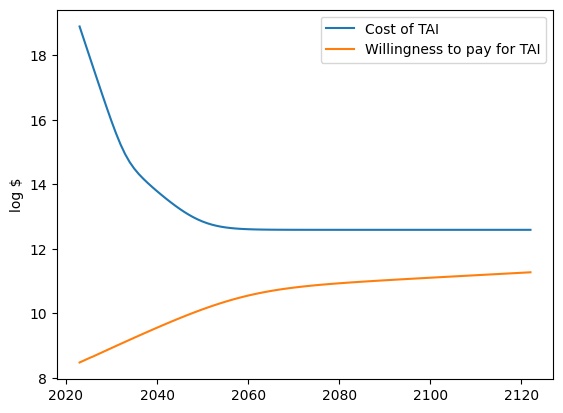

-
-
## SAMPLE RUN 16 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~201 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.8 to buy TAI (631 quadrillion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (579 septillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.4 to buy TAI (254 quadrillion) vs. willingness to pay log $ 8.4 (233 million) - 18.4 log FLOP per $ (2 quintillion)
Year: 2025 - 27.0 max log FL

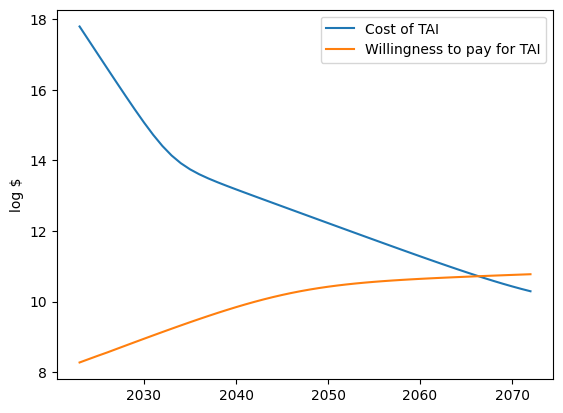

-
-
## SAMPLE RUN 17 ##
It takes 31.4 log FLOP (~25 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 3.5 years to a max of 0.048252% of GDP. GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 26.1 max log FLOP (124 septillion) available - TAI takes 31.4 log FLOP (25 nonillion) - log $ 13.1 to buy TAI (13 trillion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (196 septillion) available - TAI takes 31.3 log FLOP (19 nonillion) - log $ 12.9 to buy TAI (7 trillion) vs. willingness to pay log $ 7.9 (76 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (309 septillion) availabl

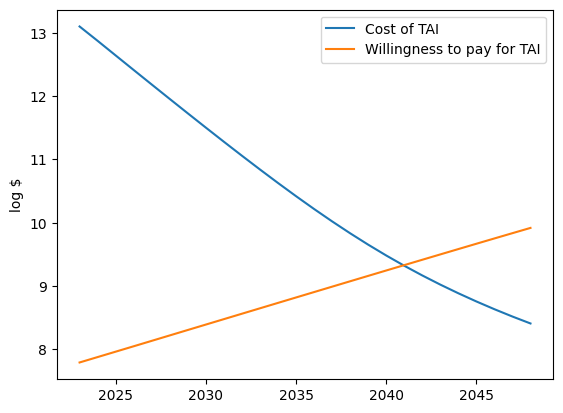

-
-
## SAMPLE RUN 18 ##
It takes 27.3 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~480 million). This doubles every 4.5 years to a max of 0.049001% of GDP. GDP grows at a rate of 1.01x per year.
---
Year: 2023 - 27.0 max log FLOP (917 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.7 (460 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.8 to buy TAI (577 million) vs. willingness to pay log $ 8.7 (534 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.4 max log FLOP (2 octillion) available - TAI take

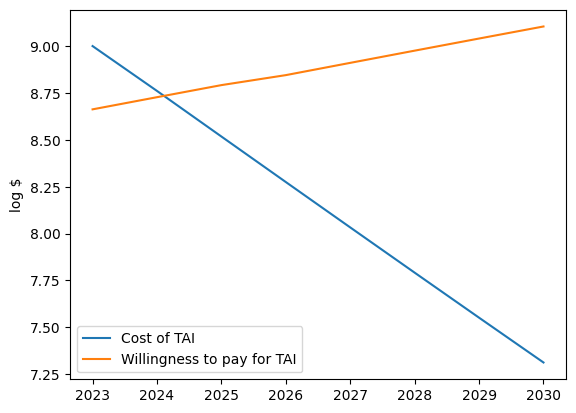

-
-
## SAMPLE RUN 19 ##
It takes 34.8 log FLOP (~63 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~168 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 2.9 years to a max of 0.174696% of GDP. GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 26.5 max log FLOP (314 septillion) available - TAI takes 34.8 log FLOP (63 decillion) - log $ 16.5 to buy TAI (32 quadrillion) vs. willingness to pay log $ 8.2 (157 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (542 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.2 to buy TAI (15 quadrillion) vs. willingness to pay log $ 8.3 (199 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (936 septilli

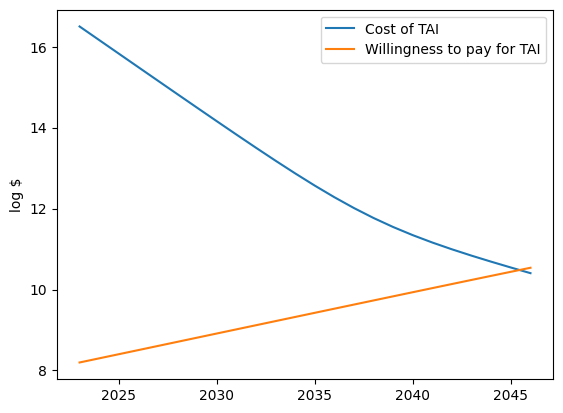

-
-
## SAMPLE RUN 20 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~790 million). This doubles every 2.1 years to a max of 0.696871% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 33.2 log FLOP (2 decillion) - log $ 14.9 to buy TAI (795 trillion) vs. willingness to pay log $ 8.9 (787 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.6 to buy TAI (432 trillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.7 max log FLOP (5 octillion) available - TAI 

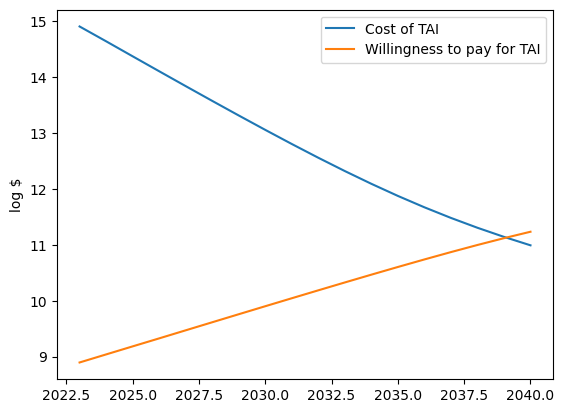

-
-
## SAMPLE RUN 21 ##
It takes 28.3 log FLOP (~20 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~46 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 3.6 years to a max of 0.059191% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.1 max log FLOP (125 septillion) available - TAI takes 28.3 log FLOP (20 octillion) - log $ 10.0 to buy TAI (10 billion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (202 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 7.9 (76 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (329 septillion) available -

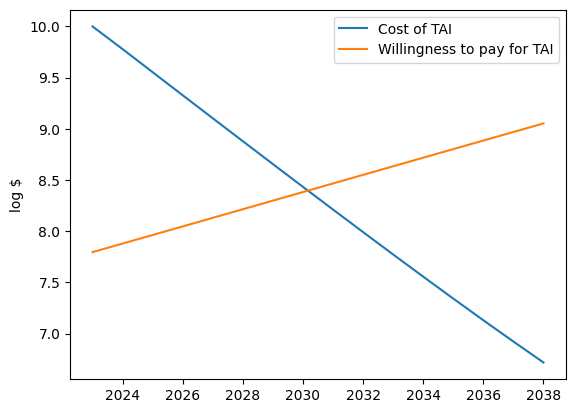

-
-
## SAMPLE RUN 22 ##
It takes 32.6 log FLOP (~398 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~538 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 2.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.006x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 32.6 log FLOP (398 nonillion) - log $ 14.3 to buy TAI (200 trillion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (358 septillion) available - TAI takes 32.5 log FLOP (285 nonillion) - log $ 14.0 to buy TAI (108 trillion) vs. willingness to pay log $ 8.1 (136 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (664 septillion) av

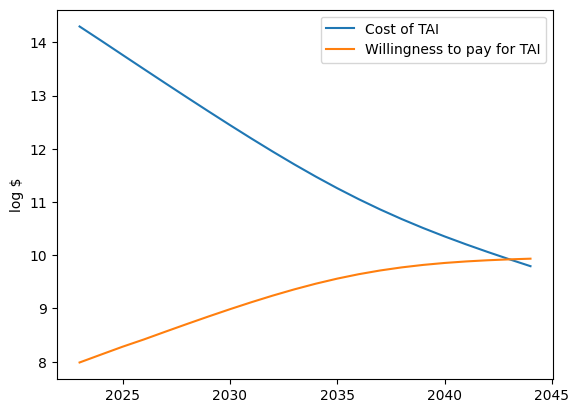

-
-
## SAMPLE RUN 23 ##
It takes 30.2 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~43 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~312 million). This doubles every 1.3 years to a max of 0.111132% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.8 max log FLOP (616 septillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.9 to buy TAI (794 billion) vs. willingness to pay log $ 8.5 (309 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.1 log FLOP (1 nonillion) - log $ 11.7 to buy TAI (467 billion) vs. willingness to pay log $ 8.7 (528 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) available - 

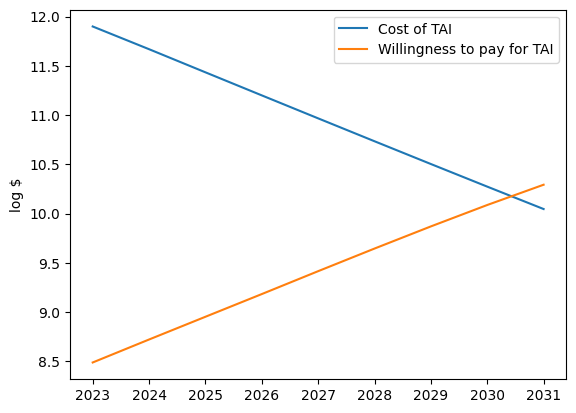

-
-
## SAMPLE RUN 24 ##
It takes 37.6 log FLOP (~40 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~956 sextillion) per 2022$USD.
We are initially willing to pay 7.5 log 2022$USD (~32 million). This doubles every 1.6 years to a max of 0.058725% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 25.8 max log FLOP (63 septillion) available - TAI takes 37.6 log FLOP (40 thousand decillion) - log $ 19.3 to buy TAI (20 quintillion) vs. willingness to pay log $ 7.5 (31 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (127 septillion) available - TAI takes 37.3 log FLOP (20 thousand decillion) - log $ 18.9 to buy TAI (8 quintillion) vs. willingness to pay log $ 7.7 (49 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max 

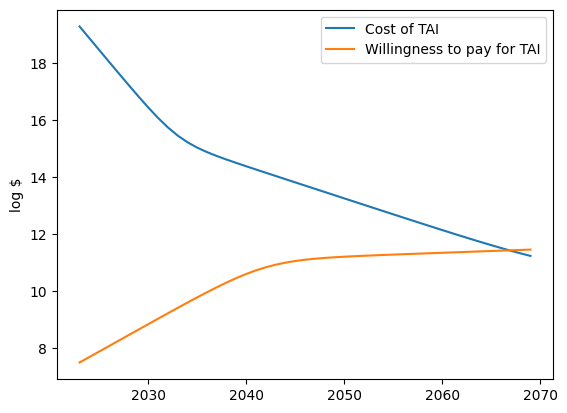

-
-
## SAMPLE RUN 25 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 2.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.2 max log FLOP (154 septillion) available - TAI takes 26.0 log FLOP (100 septillion) - log $ 7.7 to buy TAI (50 million) vs. willingness to pay log $ 7.9 (77 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 7 years)
-- robotics p_nonscaling_issue p=0.3 -> Nonscali

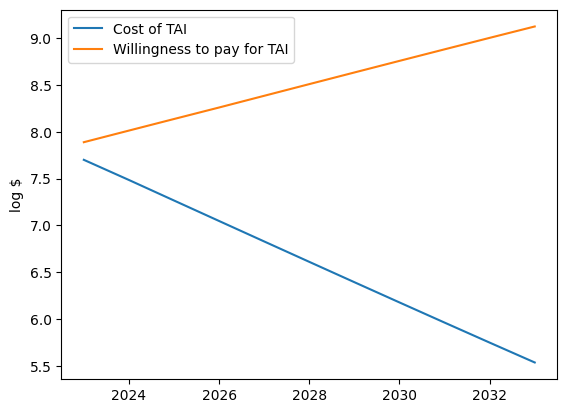

-
-
## SAMPLE RUN 26 ##
It takes 28.8 log FLOP (~63 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 2.8 years to a max of 0.062772% of GDP. GDP grows at a rate of 1.009x per year.
---
Year: 2023 - 26.3 max log FLOP (197 septillion) available - TAI takes 28.8 log FLOP (63 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (323 septillion) available - TAI takes 28.7 log FLOP (51 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.1 (126 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (529 septillion) availabl

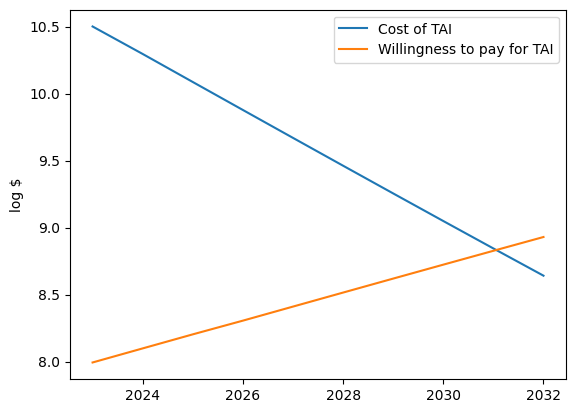

-
-
## SAMPLE RUN 27 ##
It takes 32.8 log FLOP (~631 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 3.5 years to a max of 0.189397% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.4 max log FLOP (250 septillion) available - TAI takes 32.8 log FLOP (631 nonillion) - log $ 14.5 to buy TAI (316 trillion) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (406 septillion) available - TAI takes 32.7 log FLOP (452 nonillion) - log $ 14.2 to buy TAI (170 trillion) vs. willingness to pay log $ 8.2 (153 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (661 septillion)

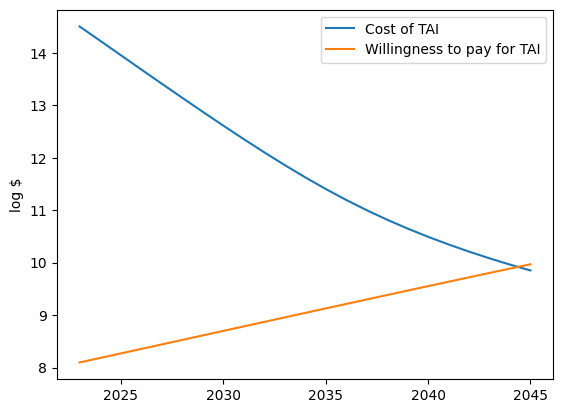

-
-
## SAMPLE RUN 28 ##
It takes 38.1 log FLOP (~126 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~223 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~248 million). This doubles every 2.6 years to a max of 0.074995% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.7 max log FLOP (487 septillion) available - TAI takes 38.1 log FLOP (126 thousand decillion) - log $ 19.8 to buy TAI (63 quintillion) vs. willingness to pay log $ 8.4 (244 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (799 septillion) available - TAI takes 37.8 log FLOP (63 thousand decillion) - log $ 19.4 to buy TAI (25 quintillion) vs. willingness to pay log $ 8.5 (318 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1

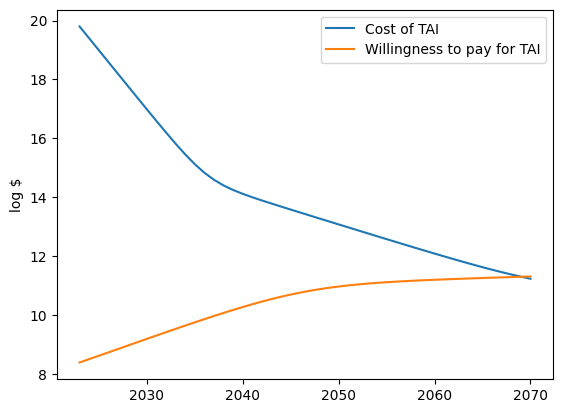

-
-
## SAMPLE RUN 29 ##
It takes 41.8 log FLOP (~631 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~314 million). This doubles every 3.6 years to a max of 0.174755% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.8 max log FLOP (621 septillion) available - TAI takes 41.8 log FLOP (631 million decillion) - log $ 23.5 to buy TAI (317 sextillion) vs. willingness to pay log $ 8.5 (311 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (983 septillion) available - TAI takes 41.5 log FLOP (316 million decillion) - log $ 23.1 to buy TAI (121 sextillion) vs. willingness to pay log $ 8.6 (378 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max

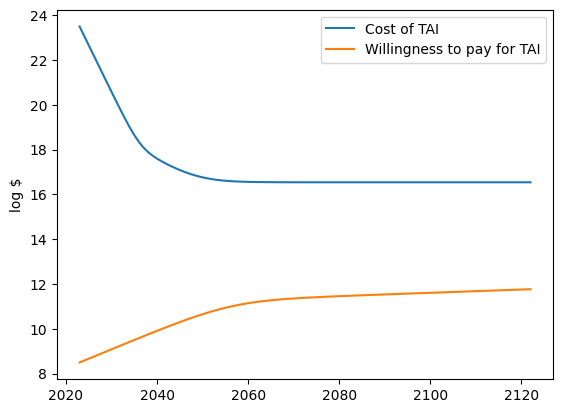

-
-
## SAMPLE RUN 30 ##
It takes 35.5 log FLOP (~316 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~702 million). This doubles every 3.3 years to a max of 0.026108% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 35.5 log FLOP (316 decillion) - log $ 17.2 to buy TAI (159 quadrillion) vs. willingness to pay log $ 8.8 (628 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 35.3 log FLOP (200 decillion) - log $ 16.9 to buy TAI (76 quadrillion) vs. willingness to pay log $ 8.9 (759 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) av

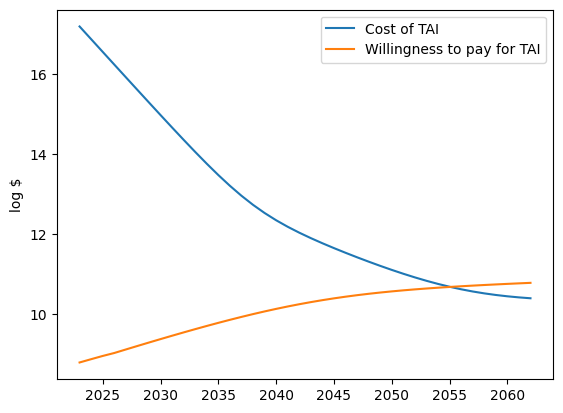

-
-
## SAMPLE RUN 31 ##
It takes 45.5 log FLOP (~3 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~48 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 2.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.036x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 45.5 log FLOP (3 trillion decillion) - log $ 27.2 to buy TAI (2 octillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (476 septillion) available - TAI takes 45.2 log FLOP (2 trillion decillion) - log $ 26.7 to buy TAI (523 septillion) vs. willingness to pay log $ 8.2 (158 million) - 18.5 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLO

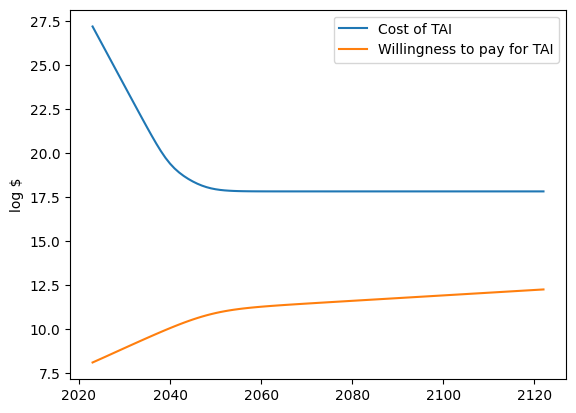

-
-
## SAMPLE RUN 32 ##
It takes 25.8 log FLOP (~63 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~35 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~248 million). This doubles every 4.1 years to a max of 0.09402% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.7 max log FLOP (490 septillion) available - TAI takes 25.8 log FLOP (63 septillion) - log $ 7.5 to buy TAI (32 million) vs. willingness to pay log $ 8.4 (245 million) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 7 years)
-- robotics p_nonscaling_issue p=0.3 -> Nonsca

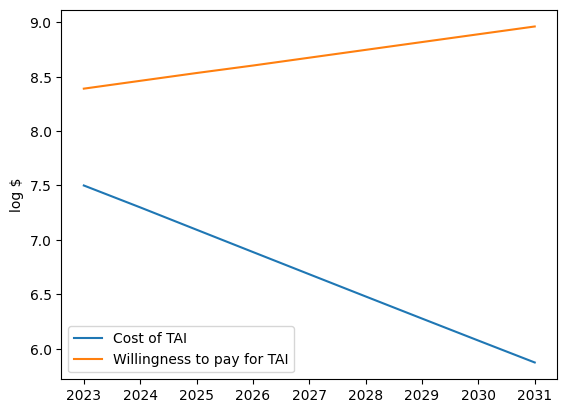

-
-
## SAMPLE RUN 33 ##
It takes 35.6 log FLOP (~398 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~31 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~62 million). This doubles every 3.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.1 max log FLOP (123 septillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 17.3 to buy TAI (200 quadrillion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (184 septillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.0 to buy TAI (100 quadrillion) vs. willingness to pay log $ 7.9 (74 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLOP (276 septillion

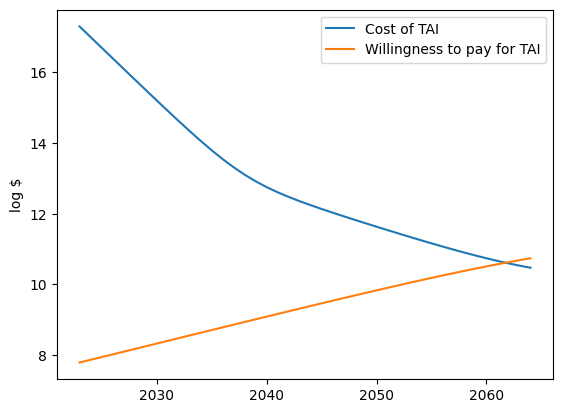

-
-
## SAMPLE RUN 34 ##
It takes 36.6 log FLOP (~4 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~430 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~156 million). This doubles every 3.9 years to a max of 0.050933% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.5 max log FLOP (308 septillion) available - TAI takes 36.6 log FLOP (4 thousand decillion) - log $ 18.3 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.2 (154 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (470 septillion) available - TAI takes 36.3 log FLOP (2 thousand decillion) - log $ 17.9 to buy TAI (779 quadrillion) vs. willingness to pay log $ 8.3 (184 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 ma

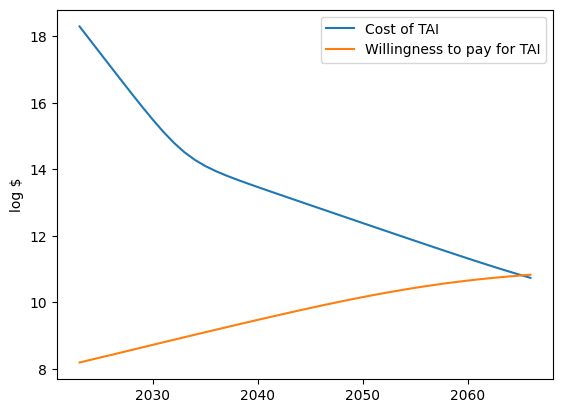

-
-
## SAMPLE RUN 35 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~255 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 2.1 years to a max of 0.354422% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.3 max log FLOP (199 septillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.0 (100 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (369 septillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.8 to buy TAI (572 billion) vs. willingness to pay log $ 8.1 (138 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (685 septillion) availa

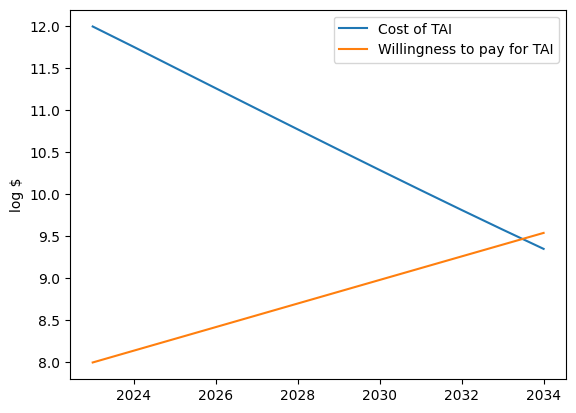

-
-
## SAMPLE RUN 36 ##
It takes 39.4 log FLOP (~3 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~344 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 4.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.2 max log FLOP (154 septillion) available - TAI takes 39.4 log FLOP (3 million decillion) - log $ 21.1 to buy TAI (1 sextillion) vs. willingness to pay log $ 7.9 (77 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (238 septillion) available - TAI takes 39.1 log FLOP (1 million decillion) - log $ 20.7 to buy TAI (481 quintillion) vs. willingness to pay log $ 8.0 (91 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (

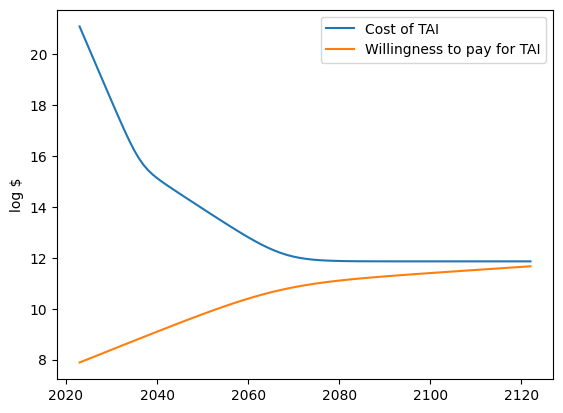

-
-
## SAMPLE RUN 37 ##
It takes 41.6 log FLOP (~398 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~244 million). This doubles every 3.3 years to a max of 0.035205% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.7 max log FLOP (472 septillion) available - TAI takes 41.6 log FLOP (398 million decillion) - log $ 23.3 to buy TAI (200 sextillion) vs. willingness to pay log $ 8.4 (237 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (768 septillion) available - TAI takes 41.3 log FLOP (199 million decillion) - log $ 22.9 to buy TAI (75 sextillion) vs. willingness to pay log $ 8.5 (290 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max 

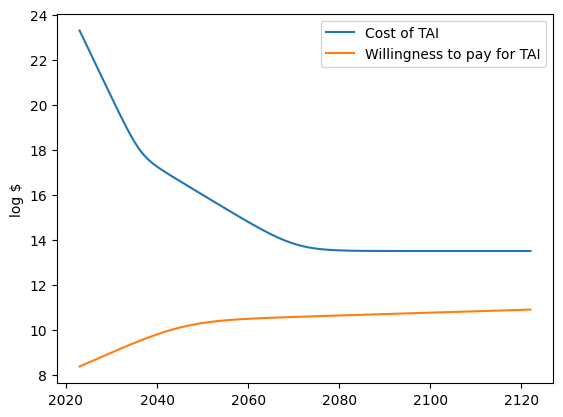

-
-
## SAMPLE RUN 38 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~60 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 1.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.8 to buy TAI (574 billion) vs. willingness to pay log $ 8.6 (388 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.4 max log FLOP (2 octillion) available - TAI 

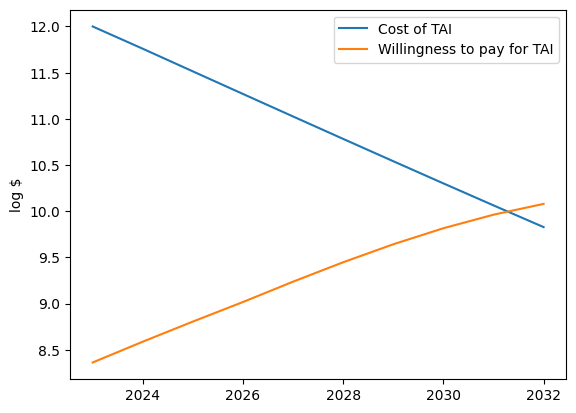

-
-
## SAMPLE RUN 39 ##
It takes 31.4 log FLOP (~25 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~38 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 1.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 31.4 log FLOP (25 nonillion) - log $ 13.1 to buy TAI (13 trillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (507 septillion) available - TAI takes 31.3 log FLOP (19 nonillion) - log $ 12.9 to buy TAI (7 trillion) vs. willingness to pay log $ 8.3 (197 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (1 octillion) available 

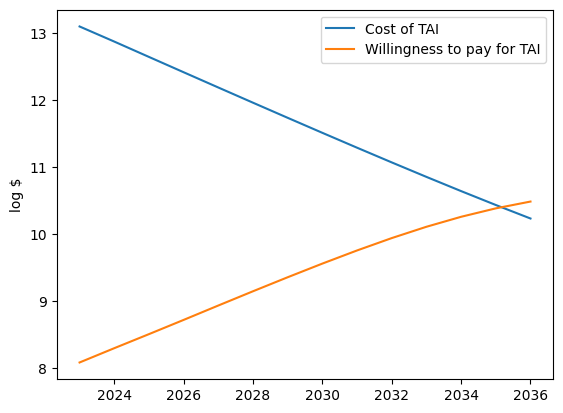

-
-
## SAMPLE RUN 40 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~29 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~380 million). This doubles every 3.0 years to a max of 0.035431% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.9 max log FLOP (724 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.6 (363 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.1 to buy TAI (12 billion) vs. willingness to pay log $ 8.7 (453 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3 max log FLOP (2 octillion) available -

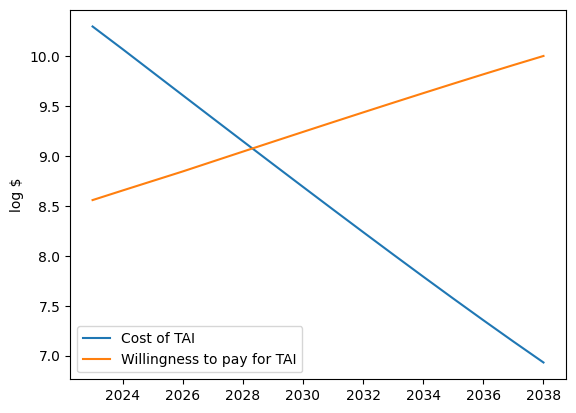

-
-
## SAMPLE RUN 41 ##
It takes 37.4 log FLOP (~25 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.3 log 2022$USD (~2 billion). This doubles every 3.8 years to a max of 0.03352% of GDP. GDP grows at a rate of 1.035x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 37.4 log FLOP (25 thousand decillion) - log $ 19.1 to buy TAI (13 quintillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 37.1 log FLOP (13 thousand decillion) - log $ 18.7 to buy TAI (5 quintillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.9 max log FLOP (7

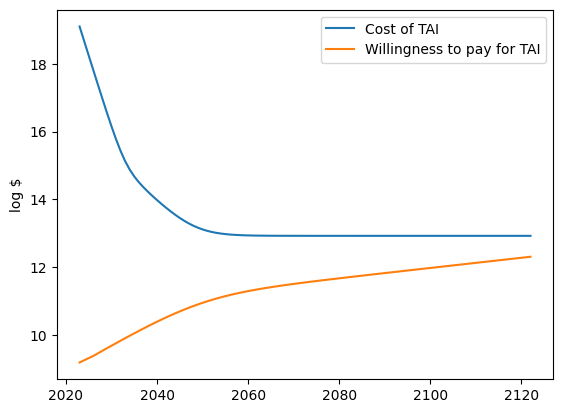

-
-
## SAMPLE RUN 42 ##
It takes 35.9 log FLOP (~794 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 2.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 35.9 log FLOP (794 decillion) - log $ 17.6 to buy TAI (398 quadrillion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (617 septillion) available - TAI takes 35.7 log FLOP (501 decillion) - log $ 17.3 to buy TAI (192 quadrillion) vs. willingness to pay log $ 8.4 (236 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (1 octillion

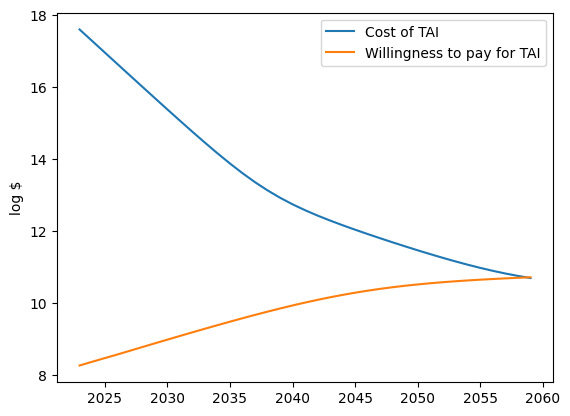

-
-
## SAMPLE RUN 43 ##
It takes 32.7 log FLOP (~501 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.7 log 2022$USD (~5 billion). This doubles every 2.9 years to a max of 0.119803% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.9 max log FLOP (9 octillion) available - TAI takes 32.7 log FLOP (501 nonillion) - log $ 14.4 to buy TAI (251 trillion) vs. willingness to pay log $ 9.6 (4 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 28.1 max log FLOP (13 octillion) available - TAI takes 32.6 log FLOP (359 nonillion) - log $ 14.2 to buy TAI (143 trillion) vs. willingness to pay log $ 9.7 (5 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 28.3 max log FLOP (20 octillion) available - 

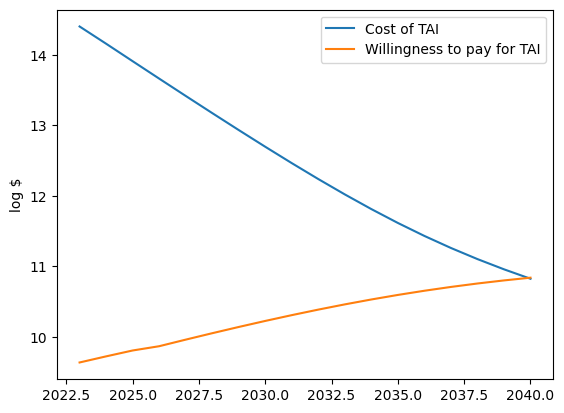

-
-
## SAMPLE RUN 44 ##
It takes 38.9 log FLOP (~794 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 4.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.035x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 38.9 log FLOP (794 thousand decillion) - log $ 20.6 to buy TAI (398 quintillion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (306 septillion) available - TAI takes 38.6 log FLOP (397 thousand decillion) - log $ 20.2 to buy TAI (149 quintillion) vs. willingness to pay log $ 8.1 (114 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 ma

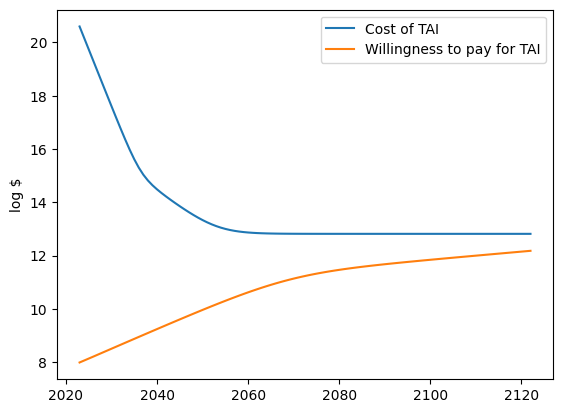

-
-
## SAMPLE RUN 45 ##
It takes 28.8 log FLOP (~63 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~32 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~156 million). This doubles every 4.5 years to a max of 0.037189% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 26.5 max log FLOP (305 septillion) available - TAI takes 28.8 log FLOP (63 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.2 (153 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (462 septillion) available - TAI takes 28.7 log FLOP (51 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.3 (178 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (700 septillion) avail

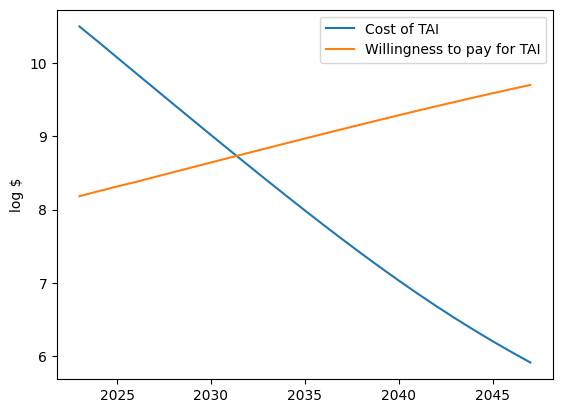

-
-
## SAMPLE RUN 46 ##
It takes 29.7 log FLOP (~501 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~472 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~475 million). This doubles every 1.8 years to a max of 0.040331% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 27.0 max log FLOP (902 septillion) available - TAI takes 29.7 log FLOP (501 octillion) - log $ 11.4 to buy TAI (251 billion) vs. willingness to pay log $ 8.7 (452 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 29.6 log FLOP (403 octillion) - log $ 11.2 to buy TAI (150 billion) vs. willingness to pay log $ 8.8 (649 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) avail

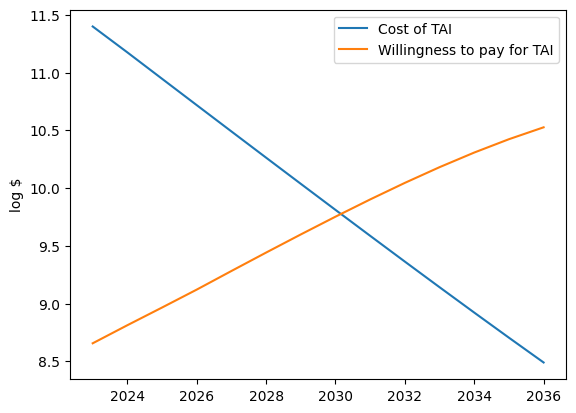

-
-
## SAMPLE RUN 47 ##
It takes 31.4 log FLOP (~25 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~389 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 1.2 years to a max of 0.025344% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.8 max log FLOP (569 septillion) available - TAI takes 31.4 log FLOP (25 nonillion) - log $ 13.1 to buy TAI (13 trillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 31.3 log FLOP (19 nonillion) - log $ 12.8 to buy TAI (7 trillion) vs. willingness to pay log $ 8.7 (487 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) available

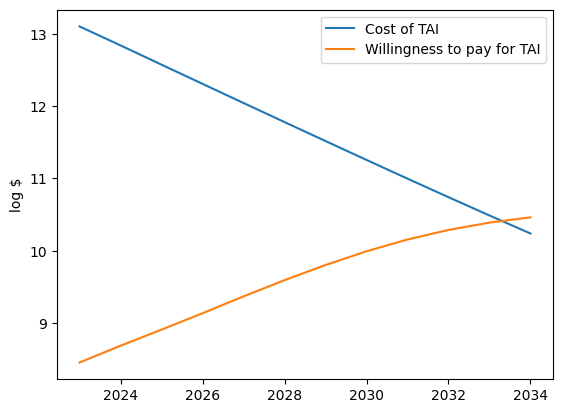

-
-
## SAMPLE RUN 48 ##
It takes 28.8 log FLOP (~63 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~393 million). This doubles every 2.3 years to a max of 0.133765% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.9 max log FLOP (774 septillion) available - TAI takes 28.8 log FLOP (63 octillion) - log $ 10.5 to buy TAI (32 billion) vs. willingness to pay log $ 8.6 (388 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.7 log FLOP (51 octillion) - log $ 10.3 to buy TAI (19 billion) vs. willingness to pay log $ 8.7 (521 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.4 max log FLOP (3 octillion) available -

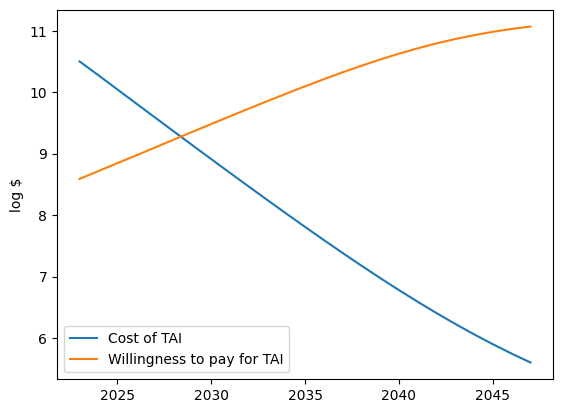

-
-
## SAMPLE RUN 49 ##
It takes 34.8 log FLOP (~63 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 2.7 years to a max of 0.030594% of GDP. GDP grows at a rate of 1.008x per year.
---
Year: 2023 - 26.0 max log FLOP (99 septillion) available - TAI takes 34.8 log FLOP (63 decillion) - log $ 16.5 to buy TAI (32 quadrillion) vs. willingness to pay log $ 7.7 (49 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (162 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.2 to buy TAI (16 quadrillion) vs. willingness to pay log $ 7.8 (64 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLOP (265 septillion) av

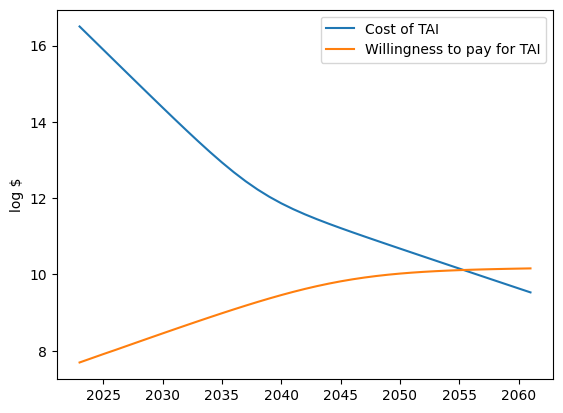

-
-
## SAMPLE RUN 50 ##
It takes 27.4 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~249 million). This doubles every 4.4 years to a max of 0.141033% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.7 max log FLOP (493 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 8.4 (247 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (757 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 8.9 to buy TAI (772 million) vs. willingness to pay log $ 8.5 (289 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) available - TAI 

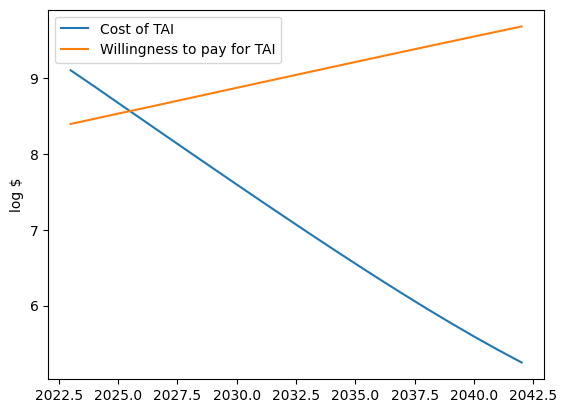

-
-
## SAMPLE RUN 51 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~106 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 3.8 years to a max of 0.063348% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.4 max log FLOP (247 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.9 to buy TAI (794 million) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (394 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.7 to buy TAI (479 million) vs. willingness to pay log $ 8.2 (148 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (630 septillion) available

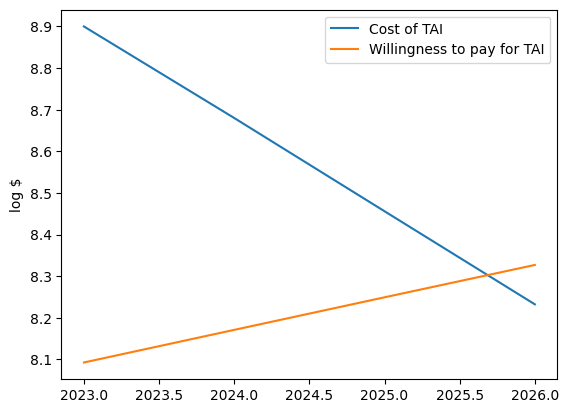

-
-
## SAMPLE RUN 52 ##
It takes 29.2 log FLOP (~158 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 3.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 29.2 log FLOP (158 octillion) - log $ 10.9 to buy TAI (79 billion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (375 septillion) available - TAI takes 29.1 log FLOP (127 octillion) - log $ 10.7 to buy TAI (50 billion) vs. willingness to pay log $ 8.2 (148 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (585 septillion) availa

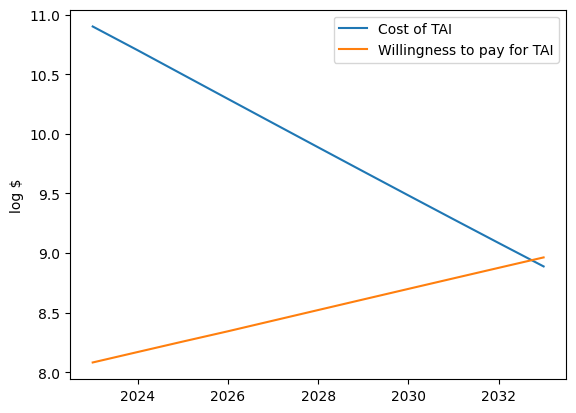

-
-
## SAMPLE RUN 53 ##
It takes 30.2 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~43 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 3.6 years to a max of 0.036536% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.2 max log FLOP (156 septillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.9 to buy TAI (794 billion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (248 septillion) available - TAI takes 30.1 log FLOP (1 nonillion) - log $ 11.7 to buy TAI (463 billion) vs. willingness to pay log $ 8.0 (94 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (395 septillion) available

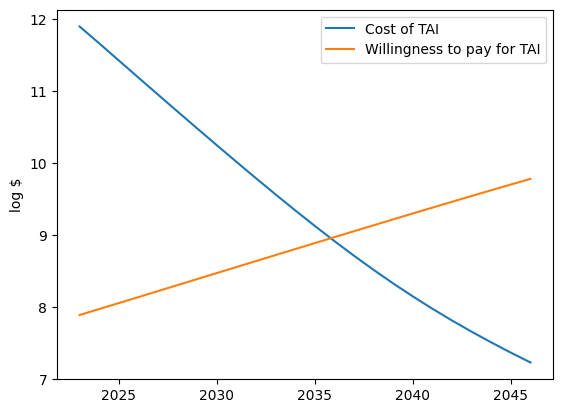

In [8]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(verbose=True)